# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [644]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [645]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [646]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [647]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [648]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [997]:
channels = ["ele", "mu"]
samples = [
    "QCD",
    "Data",
    "DYJets"
]

years = ["2017"]#, "2016", "2016APV", "2018"]

samples_dir = {
    "2017": {
        "fake": "../eos/Apr25_fakes_2017",
        "prompt": "../eos/May3_prompt_2017",
    },
}

In [998]:
events_dict = {}

In [999]:
from make_stacked_hists_fake import make_events_dict

for year in years:
    for region in ["fake", "prompt"]:
        events_dict[region] = make_events_dict([year], channels, samples_dir[year][region], samples)

INFO:root:Finding SingleElectron_Run2017E samples and should combine them under Data
INFO:root:Will fill the Data dataframe with the remaining 4972 events
INFO:root:tot event weight 4972.0 

INFO:root:Finding SingleElectron_Run2017B samples and should combine them under Data
INFO:root:Will fill the Data dataframe with the remaining 722 events
INFO:root:tot event weight 722.0 

INFO:root:Finding QCD_Pt_3200toInf samples and should combine them under QCD
INFO:root:Finding SingleElectron_Run2017C samples and should combine them under Data
INFO:root:Will fill the Data dataframe with the remaining 9400 events
INFO:root:tot event weight 9400.0 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Will fill the Data dataframe with the remaining 3629 events
INFO:root:tot event weight 3629.0 

INFO:root:Finding SingleMuon_Run2017C samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2017D samples and should combine them under Data

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Will fill the DYJets dataframe with the remaining 579277 events
INFO:root:tot event weight 102088.35813896974 

INFO:root:Finding SingleMuon_Run2017E samples and should combine them under Data
INFO:root:Finding SingleMuon_Run2017B samples and should combine them under Data
INFO:root:Finding DYJetsToLL_LHEFilterPtZ-250To400 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Will fill the DYJets dataframe with the remaining 608356 events
INFO:root:tot event weight 3859.9972730342533 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Will fill the DYJets dataframe with the remaining 78278 events
INFO:root:tot event weight 483.981202497802 

INFO:root:Finding SingleElectron_Run2017F

# Stacked hists

In [1000]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = (0, 0)

In [1001]:
for key in events_dict["fake"]["2017"]["ele"]["Data"].keys():
    print(key)

N_tight_lep
N_loose_lep
tight_lep1_pt
tight_lep1_eta
tight_lep2_pt
tight_lep2_eta
mll_tight
loose_lep1_pt
loose_lep1_eta
loose_lep2_pt
loose_lep2_eta
mll_loose
met_pt
NumFatjets
lep_fj_dr
fj_pt
fj_eta
fj_phi
event_weight


In [1015]:
vars_to_plot = [
#     "N_tight_lep",
#     "N_loose_lep",
#     "tight_lep1_pt",
#     "tight_lep1_eta",
#     "tight_lep2_pt",
#     "tight_lep2_eta",
#     "mll_tight",
#     "loose_lep1_pt",
#     "loose_lep1_eta",
#     "loose_lep2_pt",
#     "loose_lep2_eta",
#     "mll_loose",
#     "met_pt",
    "mT_loose1",
    "mT_tight1",
]

samples_to_plot = {
    "fake": 
        [
        "QCD",
        "Data",
    ],
    "prompt": 
        [
        "DYJets",    
        "Data",
    ],
}

In [1020]:
import utils

axis_dict = {
    "mll_loose": hist2.axis.Regular(40, 30, 450, name="var", label=r"Zmass [GeV]", overflow=True),
    "fj_pt": hist2.axis.Regular(30, 250, 600, name="var", label=r"Higgs candidate jet $p_T$ [GeV]", overflow=True),

    "loose_lep1_pt": hist2.axis.Regular(40, 30, 400, name="var", label=r"First loose Lepton $p_T$ [GeV]", overflow=True),    
    "loose_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"First loose Lepton |$\eta$|", overflow=True),    
    
    "loose_lep2_pt": hist2.axis.Regular(40, 30, 200, name="var", label=r"Second loose Lepton $p_T$ [GeV]", overflow=True),
    "loose_lep2_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Second loose Lepton |$\eta$|", overflow=True),

    "tight_lep1_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"First tight Lepton $p_T$ [GeV]", overflow=True),    
    "tight_lep1_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"First tight Lepton |$\eta$|", overflow=True),    
    
    "tight_lep2_pt": hist2.axis.Regular(20, 30, 200, name="var", label=r"Second tight Lepton $p_T$ [GeV]", overflow=True),
    "tight_lep2_eta": hist2.axis.Regular(25, 0, 2.4, name="var", label=r"Second tight Lepton |$\eta$|", overflow=True),
    
    "met_pt": hist2.axis.Regular(40, 0, 100, name="var", label=r"MET [GeV]", overflow=True),
    
    
    "mT_loose1": hist2.axis.Regular(40, 0, 100, name="var", label=r"mT (using loose lepton)", overflow=True),
    "mT_tight1": hist2.axis.Regular(40, 0, 100, name="var", label=r"mT (using tight lepton) [GeV]", overflow=True),
    
}

presel = {
    "fake": f"loose_lep1_pt>0",   # dummy
    "prompt": f"loose_lep1_pt>0 & mT_loose1>0",   # dummy    
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2017"]

# fill histograms
hists = {}

# for region in ["fake", "prompt"]:
for region in ["prompt"]:
    
    hists[region] = {}

    for var in vars_to_plot:

        hists[region][var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            axis_dict[var],
            storage=hist2.storage.Weight(),            
        )        

        for sample in samples_to_plot[region]:
            for year in years:
                for ch in channels:

                    df = events_dict[region][year][ch][sample]

                    df = df.query(presel[region])

                    if "eta" in var:
                        x = np.absolute(df[var])
                    else:
                        x = df[var]
                    w = df["event_weight"]

                    hists[region][var].fill(
                        samples=sample,
                        var=x,
                        weight=w,
                    )     

    for var in vars_to_plot:
        fix_neg_yields(hists[region][var])

Will plot mT_loose1 histogram
Will plot mT_tight1 histogram


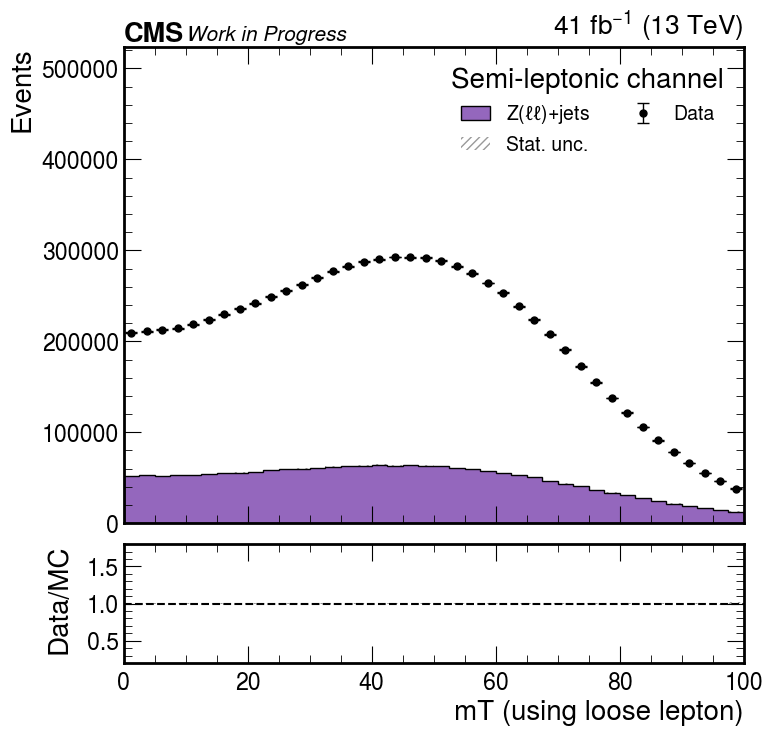

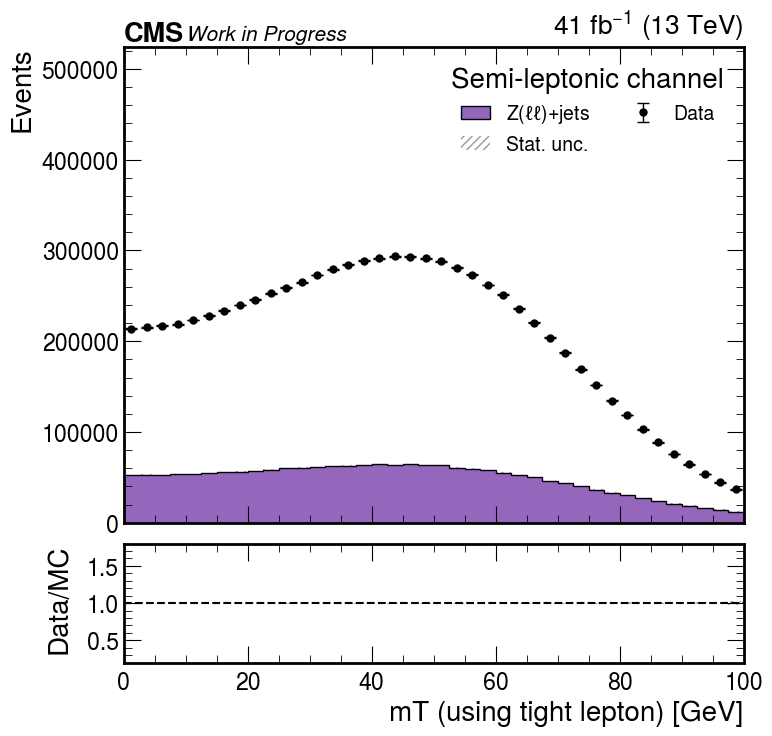

In [1021]:
# region = "fake"
region = "prompt"

if len(channels) == 2:
    text_ = "Semi-leptonic channel"
else:
    text_ = f"{ch} channel"

plt.rcParams.update({"font.size": 20})
add_data = True
add_soverb = False
    
from utils import plot_hists as plot_hists

PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/"

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists[region], years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=1,
            outpath=PATH,
            text_=text_,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=False,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )

In [934]:
def set_im_title(year, ch, region):
    if region != "SF":
        region += " rate"
    if ch == "ele":
        return f"Electron {region} {year}"
    else:
        return f"Muon {region} {year}"
    
def plot_matrix(M, region, channels, num=False, den=False):
    for ch in channels:
        fig, ax = plt.subplots(figsize=(10,10))

        if (num is False) and (den==False):
            im = ax.imshow(M[ch], vmax=1, vmin=0)#, cmap='hot', interpolation='nearest')
        else:
            im = ax.imshow(M[ch], vmin=0)#, cmap='hot', interpolation='nearest')

        ax.set_xticks(ticks=np.arange(-0.5, (len(etabinning)-1), 1), labels=etabinning)
        ax.set_yticks(ticks=np.arange(-0.5, (len(ptbinning)-1), 1), labels=ptbinning)

        ax.tick_params(axis='x', which='major', pad=8)
        ax.tick_params(axis='y', which='major', pad=8)

        # Loop over data dimensions and create text annotations.
        for i in range(len(ptbinning)-1):
            for j in range(len(etabinning)-1):
                text = ax.text(j, i, np.round(M[ch][i, j],4), ha="center", va="center")#, color="w")

        ax.set_xlabel(r"$\eta$")            
        ax.set_ylabel(r"$p_T$")
        
        plt.colorbar(im, shrink=0.8)
        plt.tight_layout()
        
        if num:
            ax.set_title(f"{ch} {year}: " + r"$tight_{Data}$", pad=20)
            if region=="SF":
                ax.set_title(f"{ch} {year}: " + r"$loose_{Data}$", pad=20)
            plt.savefig(f"{PATH}/{year}_{ch}_{region}_num.pdf")            
        elif den:
            ax.set_title(f"{ch} {year}: " + r"$loose_{Data}$", pad=20)            
            if region=="SF":
                ax.set_title(f"{ch} {year}: " + r"$loose_{DY}$", pad=20)            
            plt.savefig(f"{PATH}/{year}_{ch}_{region}_den.pdf")            
        else:
            ax.set_title(set_im_title(year,ch,region), pad=20)
            plt.savefig(f"{PATH}/{year}_{ch}_{region}.pdf")    

# Fake rate extraction (w/o SF)

In [935]:
region = "fake"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [936]:
# ptbinning = np.flip(np.round(np.linspace(30, 400, 5), 2))
ptbinning = [400, 200, 100, 30]
ptbinning

[400, 200, 100, 30]

In [937]:
etabinning = np.round(np.linspace(0, 2.4, 4), 2)
etabinning

array([0. , 0.8, 1.6, 2.4])

In [938]:
FR = {}
for ch in channels:
    FR[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(FR[ch].shape)

(3, 3)
(3, 3)


In [939]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]["Data"]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt = (df["loose_lep1_pt"] > low_pt) & (df["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta = (df["loose_lep1_eta"] > low_eta) & (df["loose_lep1_eta"] < high_eta)
    
            # get FR
            tight = df["N_tight_lep"][msk_pt & msk_eta].sum()
            loose = df["N_loose_lep"][msk_pt & msk_eta].sum()
            
            FR[ch][i,j] = tight/loose
            
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {FR[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.25
   etabin (0.80, 1.60); tight/loose: 0.20
   etabin (1.60, 2.40); tight/loose: 0.15
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.16
   etabin (0.80, 1.60); tight/loose: 0.15
   etabin (1.60, 2.40); tight/loose: 0.16
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 0.50
   etabin (0.80, 1.60); tight/loose: 0.53
   etabin (1.60, 2.40); tight/loose: 0.51
----------------------------
2017, mu channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.97
   etabin (0.80, 1.60); tight/loose: 0.96
   etabin (1.60, 2.40); tight/loose: 1.00
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.86
   etabin (0.80, 1.60); tight/loose: 0.88
   etabin (1.60, 2.40); tight/loose: 0.87
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 0.58
   etabin (0.80, 1.60); tight/loose: 0.57
   etabin (1.60, 2.40); tight/loose: 0.55
------------------------

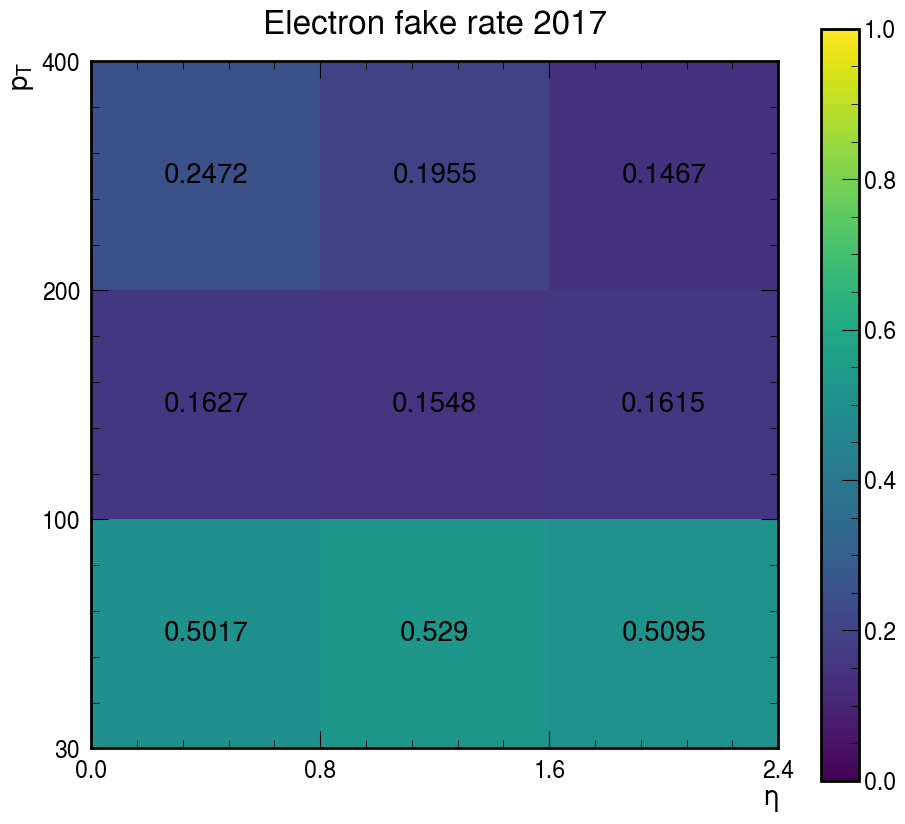

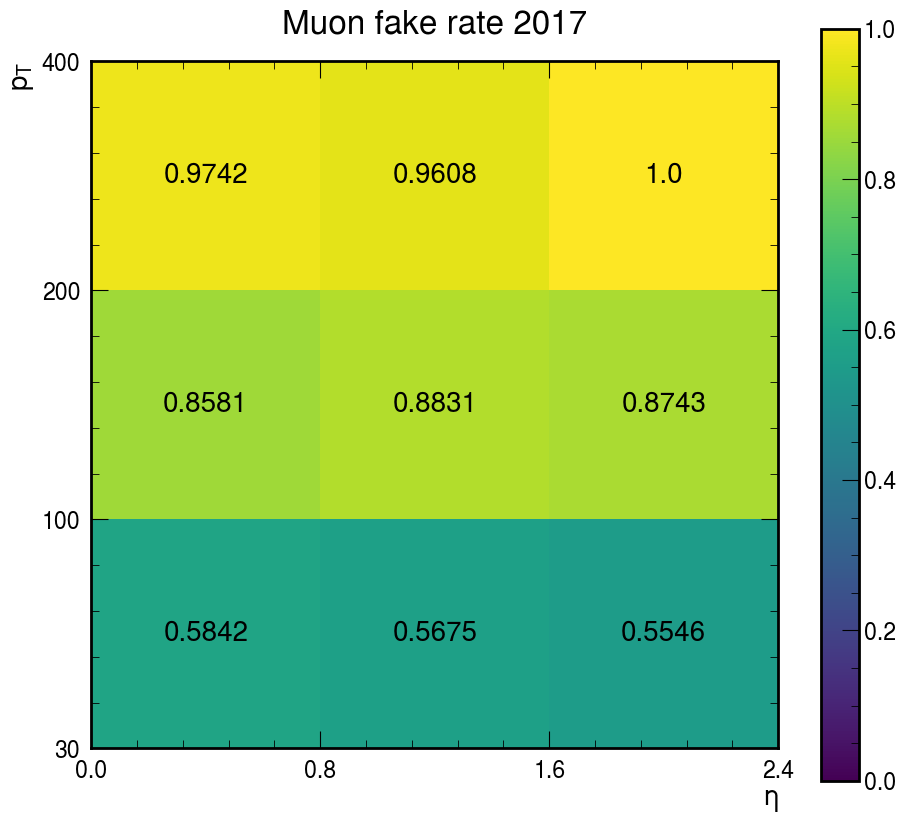

In [940]:
# plot_matrix(FR, region, channels, num=True)
# plot_matrix(FR, region, channels, den=True)
plot_matrix(FR, region, channels)

# Prompt rate

In [902]:
region = "prompt"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [972]:
# ptbinning = np.flip(np.round(np.linspace(30, 400, 5), 2))
ptbinning = [400, 200, 100, 30]
ptbinning

[400, 200, 100, 30]

In [973]:
etabinning = np.round(np.linspace(0, 2.4, 4),2)
etabinning

array([0. , 0.8, 1.6, 2.4])

In [974]:
PR = {}
for ch in channels:
    PR[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(PR[ch].shape)

(3, 3)
(3, 3)


In [975]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]["Data"]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt = (df["loose_lep1_pt"] > low_pt) & (df["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta = (df["loose_lep1_eta"] > low_eta) & (df["loose_lep1_eta"] < high_eta)
    
            # get FR
            tight = df["N_tight_lep"][msk_pt & msk_eta].sum()
            loose = df["N_loose_lep"][msk_pt & msk_eta].sum()
            
            PR[ch][i,j] = tight/loose
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {PR[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.88
   etabin (0.80, 1.60); tight/loose: 0.90
   etabin (1.60, 2.40); tight/loose: 0.91
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.91
   etabin (0.80, 1.60); tight/loose: 0.90
   etabin (1.60, 2.40); tight/loose: 0.90
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 0.91
   etabin (0.80, 1.60); tight/loose: 0.91
   etabin (1.60, 2.40); tight/loose: 0.91
----------------------------
2017, mu channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.97
   etabin (0.80, 1.60); tight/loose: 0.96
   etabin (1.60, 2.40); tight/loose: 0.95
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.97
   etabin (0.80, 1.60); tight/loose: 0.97
   etabin (1.60, 2.40); tight/loose: 0.95
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 0.95
   etabin (0.80, 1.60); tight/loose: 0.95
   etabin (1.60, 2.40); tight/loose: 0.95
------------------------

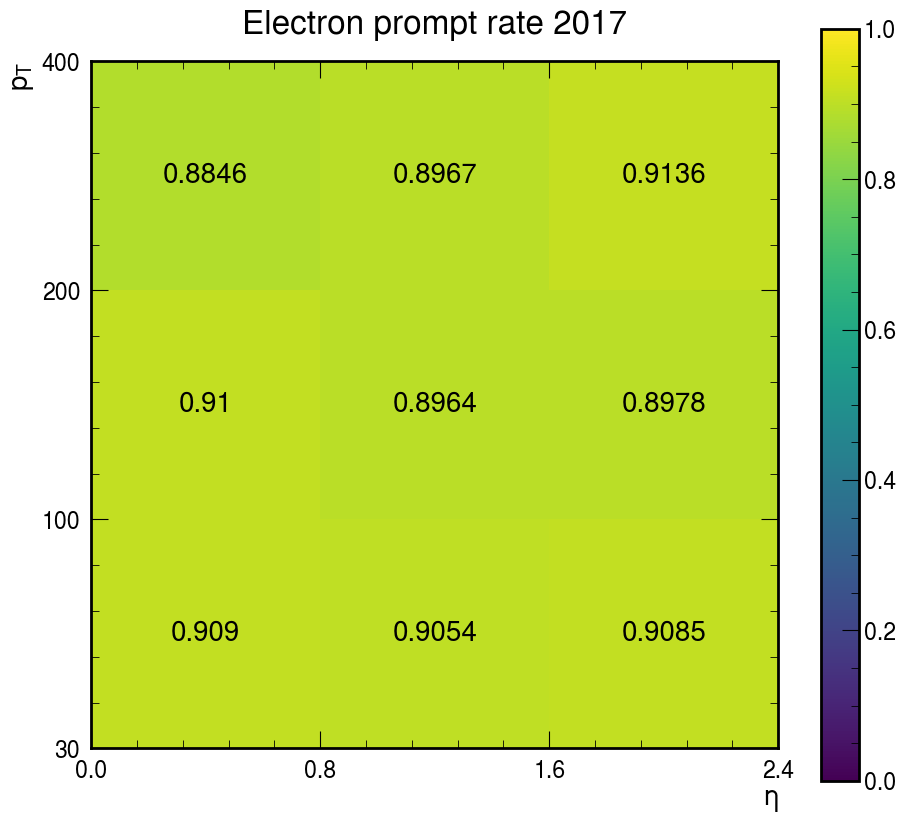

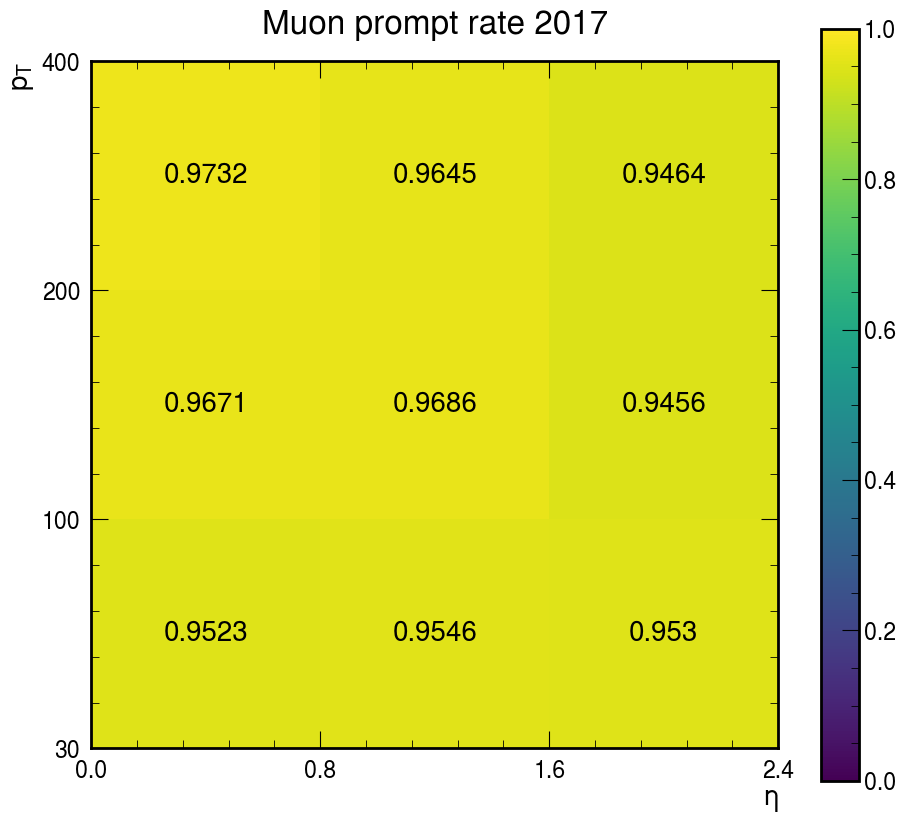

In [976]:
# plot_matrix(PR, region, channels, num=True)
# plot_matrix(PR, region, channels, den=True)
plot_matrix(PR, region, channels)

# SF

In [979]:
region = "prompt"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [980]:
# ptbinning = np.flip(np.round(np.linspace(30, 400, 5), 2))
ptbinning = [400, 200, 100, 30]
ptbinning

[400, 200, 100, 30]

In [981]:
etabinning = np.round(np.linspace(0, 2.4, 4),2)
etabinning

array([0. , 0.8, 1.6, 2.4])

In [982]:
SF = {}
for ch in channels:
    SF[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(SF[ch].shape)

(3, 3)
(3, 3)


In [989]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt_data = (df["Data"]["loose_lep1_pt"] > low_pt) & (df["Data"]["loose_lep1_pt"] < high_pt)
        msk_pt_dyjets = (df["DYJets"]["loose_lep1_pt"] > low_pt) & (df["DYJets"]["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta_data = (df["Data"]["loose_lep1_eta"] > low_eta) & (df["Data"]["loose_lep1_eta"] < high_eta)
            msk_eta_dyjets = (df["DYJets"]["loose_lep1_eta"] > low_eta) & (df["DYJets"]["loose_lep1_eta"] < high_eta)            
    
            # get FR
            loose_data = df["Data"]["N_loose_lep"][msk_pt_data & msk_eta_data].sum()
            loose_dyjets = df["DYJets"]["N_loose_lep"][msk_pt_dyjets & msk_eta_dyjets].sum()
            
            SF[ch][i,j] = loose_data/loose_dyjets
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {SF[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.01
   etabin (0.80, 1.60); tight/loose: 0.01
   etabin (1.60, 2.40); tight/loose: 0.01
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.03
   etabin (0.80, 1.60); tight/loose: 0.03
   etabin (1.60, 2.40); tight/loose: 0.03
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 1.00
   etabin (0.80, 1.60); tight/loose: 0.99
   etabin (1.60, 2.40); tight/loose: 0.95
----------------------------
2017, mu channel:
   ptbin (200.00, 400.00)
   etabin (0.00, 0.80); tight/loose: 0.01
   etabin (0.80, 1.60); tight/loose: 0.01
   etabin (1.60, 2.40); tight/loose: 0.01
   ptbin (100.00, 200.00)
   etabin (0.00, 0.80); tight/loose: 0.04
   etabin (0.80, 1.60); tight/loose: 0.04
   etabin (1.60, 2.40); tight/loose: 0.04
   ptbin (30.00, 100.00)
   etabin (0.00, 0.80); tight/loose: 1.30
   etabin (0.80, 1.60); tight/loose: 1.30
   etabin (1.60, 2.40); tight/loose: 1.33
------------------------

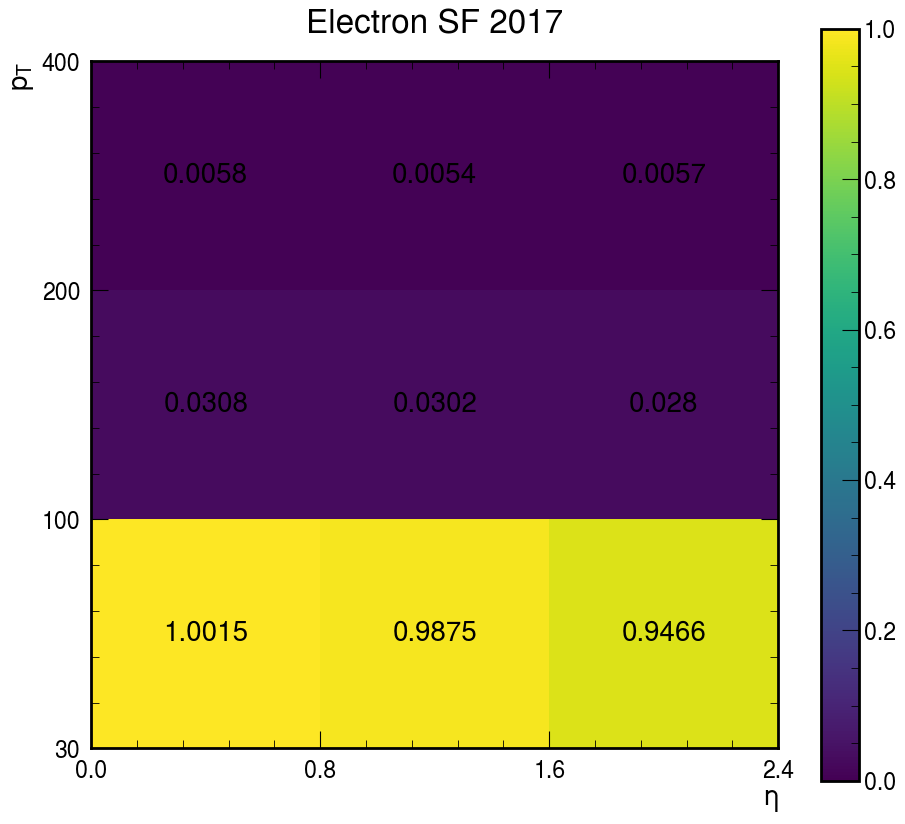

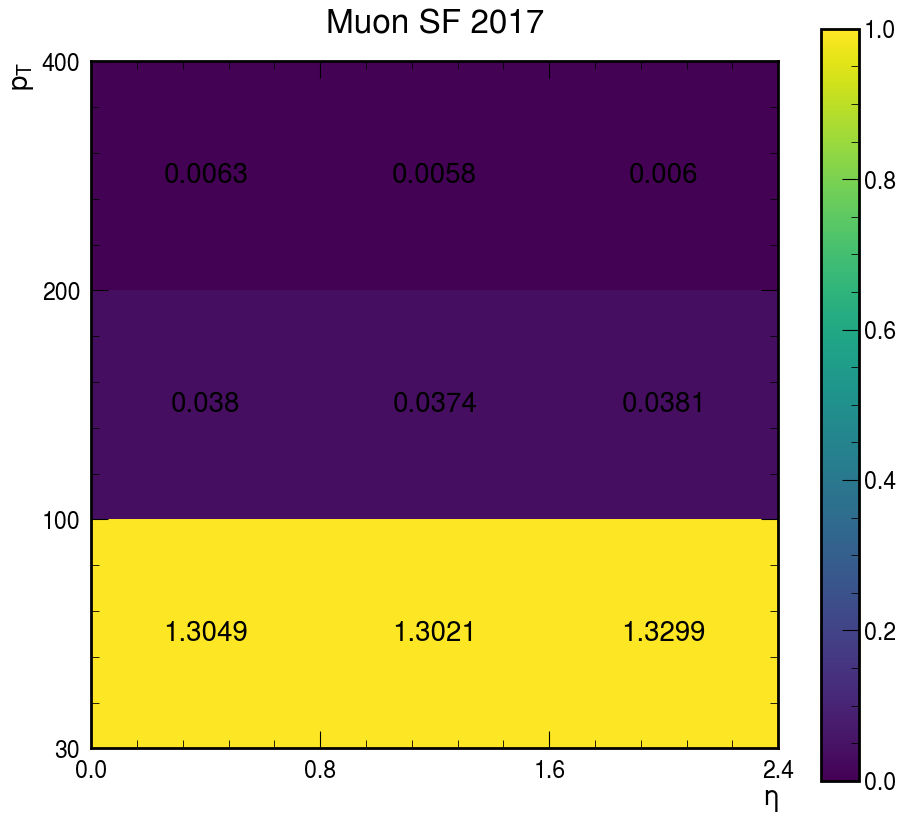

In [990]:
# plot_matrix(SF, "SF", channels, num=True)
# plot_matrix(SF, "SF", channels, den=True)
plot_matrix(SF, "SF", channels)

In [995]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]

    # get FR
    loose_data = df["Data"]["N_loose_lep"].sum()
    loose_dyjets = df["DYJets"]["N_loose_lep"].sum()

    print("SF:", loose_data/loose_dyjets)
    print("----------------------------")

2017, ele channel:
SF: 0.6102147982578899
----------------------------
2017, mu channel:
SF: 0.9580618929762115
----------------------------


# Fake rate extraction (with SF)

In [515]:
region = "fake"
year = "2017"
channels = [
    "ele",
    "mu"
]

In [579]:
ptbinning = np.flip(np.round(np.linspace(30, 400, 5),2))
ptbinning

array([400. , 307.5, 215. , 122.5,  30. ])

In [580]:
etabinning = np.round(np.linspace(0, 2.4, 5),2)
etabinning

array([0. , 0.6, 1.2, 1.8, 2.4])

In [581]:
FR = {}
for ch in channels:
    FR[ch] = np.zeros((len(ptbinning)-1,len(etabinning)-1))
    print(FR[ch].shape)

(4, 4)
(4, 4)


In [582]:
for ch in channels:
    print(f"{year}, {ch} channel:")    
    
    df = events_dict[region][year][ch]["Data"]
    
    for i in range(len(ptbinning)-1):
        high_pt = ptbinning[i]
        low_pt = ptbinning[i+1]
        
        msk_pt = (df["loose_lep1_pt"] > low_pt) & (df["loose_lep1_pt"] < high_pt)
        
        print(f"   ptbin ({low_pt:.2f}, {high_pt:.2f})")
        
        for j in range(len(etabinning)-1):        
        
            low_eta = etabinning[j]
            high_eta = etabinning[j+1]

            msk_eta = (df["loose_lep1_eta"] > low_eta) & (df["loose_lep1_eta"] < high_eta)
    
            # get FR
            tight = df["N_tight_lep"][msk_pt & msk_eta].sum()
            loose = df["N_loose_lep"][msk_pt & msk_eta].sum()
            
            FR[ch][i,j] = tight/loose
            
            print(f"   etabin ({low_eta:.2f}, {high_eta:.2f}); tight/loose: {FR[ch][i,j]:.2f}")    
    print("----------------------------")

2017, ele channel:
   ptbin (307.50, 400.00)
   etabin (0.00, 0.60); tight/loose: 0.89
   etabin (0.60, 1.20); tight/loose: 0.87
   etabin (1.20, 1.80); tight/loose: 0.93
   etabin (1.80, 2.40); tight/loose: 0.89
   ptbin (215.00, 307.50)
   etabin (0.00, 0.60); tight/loose: 0.89
   etabin (0.60, 1.20); tight/loose: 0.89
   etabin (1.20, 1.80); tight/loose: 0.91
   etabin (1.80, 2.40); tight/loose: 0.89
   ptbin (122.50, 215.00)
   etabin (0.00, 0.60); tight/loose: 0.91
   etabin (0.60, 1.20); tight/loose: 0.90
   etabin (1.20, 1.80); tight/loose: 0.90
   etabin (1.80, 2.40); tight/loose: 0.89
   ptbin (30.00, 122.50)
   etabin (0.00, 0.60); tight/loose: 0.91
   etabin (0.60, 1.20); tight/loose: 0.91
   etabin (1.20, 1.80); tight/loose: 0.91
   etabin (1.80, 2.40); tight/loose: 0.91
----------------------------
2017, mu channel:
   ptbin (307.50, 400.00)
   etabin (0.00, 0.60); tight/loose: 0.97
   etabin (0.60, 1.20); tight/loose: 0.95
   etabin (1.20, 1.80); tight/loose: 0.96
   etab

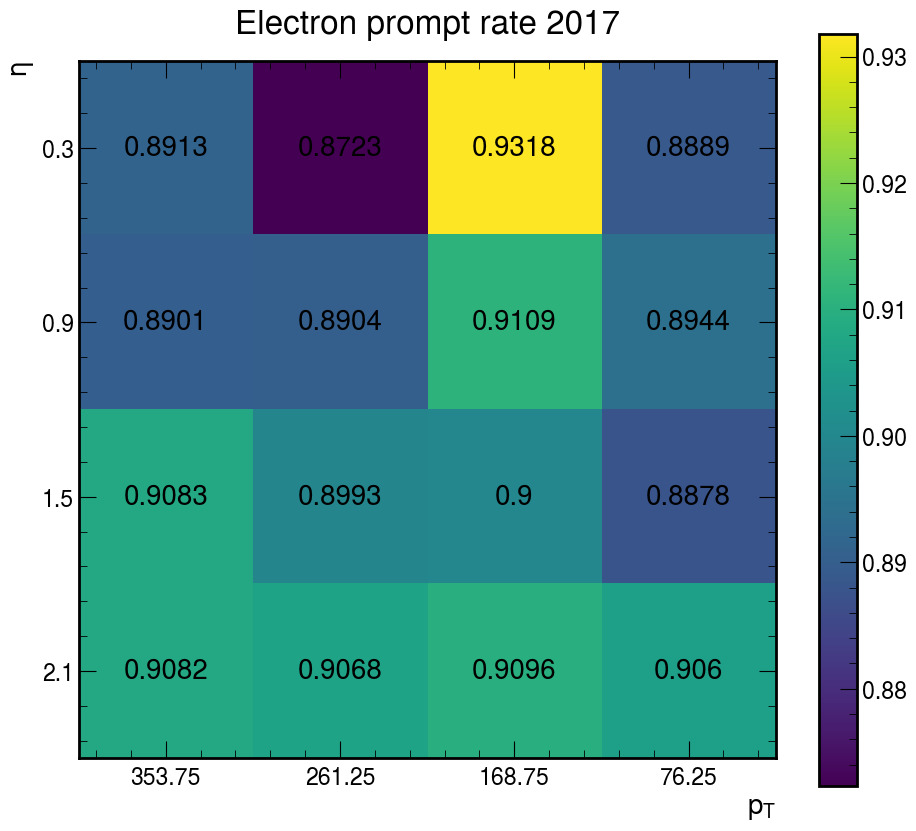

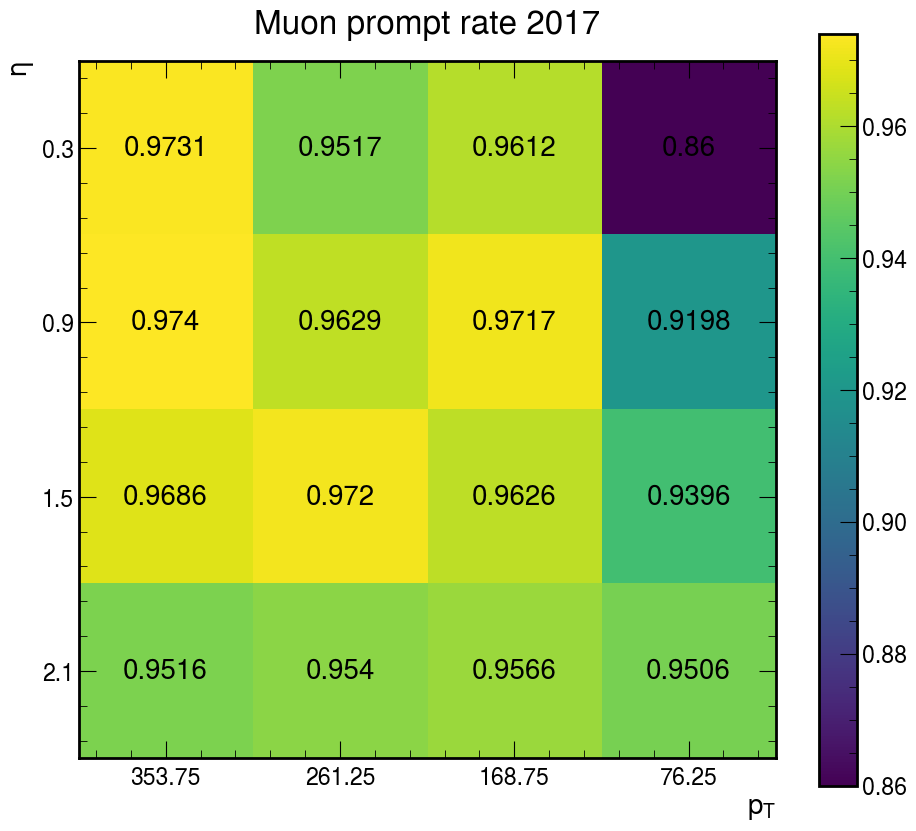

In [583]:
for ch in channels:
    fig, ax = plt.subplots(figsize=(10,10))

    im = ax.imshow(FR[ch])#, cmap='hot', interpolation='nearest')

    ax.set_xticks(ticks=range(FR[ch].shape[0]), labels=np.round(np.convolve(ptbinning, [0.5, 0.5], "valid"),2))
    ax.set_yticks(ticks=range(FR[ch].shape[1]), labels=np.round(np.convolve(etabinning, [0.5, 0.5], "valid"),2))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ptbinning)-1):
        for j in range(len(etabinning)-1):
            text = ax.text(j, i, np.round(FR[ch][i, j],4), ha="center", va="center")#, color="w")

    ax.set_xlabel(r"$p_T$")
    ax.set_ylabel(r"$\eta$")

    ax.set_title(set_im_title(year,ch,region), pad=20)

    plt.colorbar(im, shrink=0.8)
    plt.tight_layout()
    
    plt.savefig(f"{PATH}/{year}_{ch}_FR.pdf")

In [ ]:
TOT_FR = FR + 

In [ ]:
for ch in channels:
    fig, ax = plt.subplots(figsize=(10,10))

    im = ax.imshow(SF[ch], vmin=0)#, cmap='hot', interpolation='nearest')

    ax.set_xticks(ticks=range(SF[ch].shape[0]), labels=np.round(np.convolve(ptbinning, [0.5, 0.5], "valid"),2))
    ax.set_yticks(ticks=range(SF[ch].shape[1]), labels=np.round(np.convolve(etabinning, [0.5, 0.5], "valid"),2))

    # Loop over data dimensions and create text annotations.
    for i in range(len(ptbinning)-1):
        for j in range(len(etabinning)-1):
            text = ax.text(j, i, np.round(SF[ch][i, j],4), ha="center", va="center")#, color="w")

    ax.set_xlabel(r"$p_T$")
    ax.set_ylabel(r"$\eta$")

    ax.set_title(set_im_title(year,ch,"SF"), pad=20)

    plt.colorbar(im, shrink=0.8)
    plt.tight_layout()
    
    plt.savefig(f"{PATH}/{year}_{ch}_SF.pdf")